# Advanced Pinch Detection Lab
_Dual-mode detector for stationary and walking scenarios_

This notebook implements sophisticated pinch detection with separate algorithms optimized for:
- **Stationary detection**: 4-component z-score fusion with robust statistics
- **Walking detection**: Advanced signal processing with correlation analysis and waveform validation

## Features
- Robust MAD-based statistics (resistant to outliers)
- Multi-gate filtering (acceleration + gyroscope)
- Adaptive thresholding
- Cross-correlation validation (walking mode)
- Energy ratio analysis
- Easy parameter experimentation

In [1]:
# Cell 1: Imports and Core Utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sp_signal
from scipy.signal import correlate
import warnings
warnings.filterwarnings('ignore')

# Plot configuration
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')

def resolve_path(p):
    """Smart path resolution"""
    for candidate in [p, p.strip(), p.replace('  ', ' ')]:
        if os.path.exists(candidate):
            return candidate
    return p

def load_wrist_data(filepath):
    """Load and preprocess wrist motion data (adapted for your format)"""
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples from {filepath}")
    print(f"Columns: {list(df.columns)}")
    
    # Use seconds_elapsed for proper time series
    if 'seconds_elapsed' in df.columns:
        t = df['seconds_elapsed'].values
        print("Using 'seconds_elapsed' column for time")
    else:
        # Fallback to time column with normalization
        t_raw = df['time'].values
        t = t_raw - t_raw[0]  # Start from 0
        if t[-1] > 3600:  # More than 1 hour suggests epoch time
            t = t / 1000.0  # Convert from ms to seconds
            if t[-1] > 3600:  # Still too large, try microseconds
                t = t / 1000.0
        print("Using normalized 'time' column")
    
    # Calculate sampling rate
    dt = np.median(np.diff(t))
    fs = 1.0 / dt if dt > 0 else 100.0
    
    print(f"Sampling rate: {fs:.1f} Hz")
    print(f"Duration: {t[-1] - t[0]:.2f} s")
    
    # Extract signals using your column names
    acc_cols = ['accelerationX', 'accelerationY', 'accelerationZ']
    gyro_cols = ['rotationRateX', 'rotationRateY', 'rotationRateZ']
    
    acc_xyz = df[acc_cols].values
    gyro_xyz = df[gyro_cols].values
    
    # Compute magnitudes
    acc_mag = np.sqrt(np.sum(acc_xyz**2, axis=1))
    gyro_mag = np.sqrt(np.sum(gyro_xyz**2, axis=1))
    
    print(f"Acceleration range: {acc_mag.min():.3f} to {acc_mag.max():.3f} g")
    print(f"Gyroscope range: {gyro_mag.min():.3f} to {gyro_mag.max():.3f} rad/s")
    
    return {
        'time': t,
        'fs': fs,
        'acc_mag': acc_mag,
        'gyro_mag': gyro_mag,
        'acc_xyz': acc_xyz,
        'gyro_xyz': gyro_xyz,
        'df': df
    }

print("✓ Core utilities loaded")

✓ Core utilities loaded


In [2]:
# Cell 2: Signal Processing Functions

def hp_moving_mean(x, fs, win=0.5):
    """High-pass filter using moving mean subtraction"""
    w = max(1, int(round(win * fs)))
    return x - pd.Series(x).rolling(w, 1, center=True).mean().values

def bandpass(x, fs, lo, hi, order=3):
    """Bandpass filter"""
    nyq = fs / 2
    if lo >= nyq or hi >= nyq:
        return x  # Skip filtering if frequencies too high
    b, a = sp_signal.butter(order, [lo/nyq, hi/nyq], btype='band')
    return sp_signal.filtfilt(b, a, x)

def gait_lowband(x, fs, lo=0.7, hi=3.0, order=3):
    """Low-frequency gait filter"""
    nyq = fs / 2
    if lo >= nyq or hi >= nyq:
        return x
    b, a = sp_signal.butter(order, [lo/nyq, hi/nyq], btype='band')
    return sp_signal.filtfilt(b, a, x)

def rms_envelope(x, fs, win=0.06):
    """RMS envelope computation"""
    w = max(1, int(round(win * fs)))
    return np.sqrt(pd.Series(x**2).rolling(w, 1, center=True).mean().values + 1e-12)

def robust_z(x, fs, win=3.0):
    """Robust z-score using MAD (Median Absolute Deviation)"""
    w = max(3, int(round(win * fs)))
    s = pd.Series(x)
    
    # Rolling median and MAD
    med = s.rolling(w, max(1, w//4), center=True).median()
    mad = s.rolling(w, max(1, w//4), center=True).apply(
        lambda v: np.median(np.abs(v - np.median(v))), raw=False
    )
    
    # Handle zero MAD
    mad = mad.replace(0, np.nan).fillna(
        mad.median() if np.isfinite(mad.median()) else 1.0
    )
    
    # Robust z-score
    return ((s - med) / (1.4826 * mad + 1e-9)).values

def adaptive_threshold(score, fs, win=3.0, k_mad=5.5):
    """Compute adaptive threshold using MAD"""
    w = max(3, int(round(win * fs)))
    return pd.Series(score).rolling(w, max(1, int(round(0.75*fs))), center=True).apply(
        lambda v: np.median(v) + k_mad * (1.4826 * np.median(np.abs(v - np.median(v))) + 1e-9),
        raw=False
    ).values

print("✓ Signal processing functions loaded")

✓ Signal processing functions loaded


In [3]:
# Cell 3: Stationary Pinch Detector

def detect_stationary(data, params):
    """Stationary pinch detection using 4-component z-score fusion"""
    t, fs = data['time'], data['fs']
    a, g = data['acc_mag'], data['gyro_mag']
    
    # High-pass filter and derivatives
    a_hp = hp_moving_mean(a, fs, params['hp_win'])
    da = np.gradient(a_hp, 1.0/fs)
    dg = np.gradient(g, 1.0/fs)
    
    # Robust z-scores for all components
    z_a = robust_z(a_hp, fs, params['thr_win'])
    z_g = robust_z(g, fs, params['thr_win'])
    z_da = robust_z(np.abs(da), fs, params['thr_win'])
    z_dg = robust_z(np.abs(dg), fs, params['thr_win'])
    
    # Fusion score (4-component)
    score = np.sqrt(
        np.maximum(z_a, 0)**2 + 
        np.maximum(z_g, 0)**2 + 
        np.maximum(z_da, 0)**2 + 
        np.maximum(z_dg, 0)**2
    )
    
    # Adaptive threshold
    thr = adaptive_threshold(score, fs, params['thr_win'], params['k_mad'])
    
    # Peak detection with gating
    n = len(score)
    refr = int(round(params['refractory_s'] * fs))
    pw = int(round(params['peakwin_s'] * fs))
    gate = int(round(params['gatewin_s'] * fs))
    
    idxs = []
    last = -10**9
    
    for i in np.where(score > thr)[0]:
        # Refractory period check
        if i - last < refr:
            continue
            
        # Local maxima check
        i0 = max(0, i - pw)
        i1 = min(n, i + pw + 1)
        if i != i0 + np.argmax(score[i0:i1]):
            continue
            
        # Gate checks
        g0 = max(0, i - gate)
        g1 = min(n, i + gate + 1)
        if (np.nanmax(a_hp[g0:g1]) < params['acc_gate'] or 
            np.nanmax(g[g0:g1]) < params['gyro_gate']):
            continue
            
        # Minimum inter-event interval
        if len(idxs) and (i - idxs[-1]) < int(round(params['min_iei_s'] * fs)):
            continue
            
        idxs.append(i)
        last = i
    
    # Calculate event metrics
    events = []
    for idx in idxs:
        events.append({
            'index': idx,
            'time': t[idx],
            'score': score[idx],
            'acc_peak': a_hp[idx],
            'gyro_peak': g[idx],
            'threshold': thr[idx]
        })
    
    return {
        'idxs': np.array(idxs, dtype=int),
        'events': events,
        'score': score,
        'threshold': thr,
        'components': {'z_a': z_a, 'z_g': z_g, 'z_da': z_da, 'z_dg': z_dg},
        'a_hp': a_hp,
        'detector_type': 'stationary'
    }

print("✓ Stationary detector loaded")

✓ Stationary detector loaded


In [4]:
# Cell 4: Walking Pinch Detector

def detect_walking(data, params):
    """Walking pinch detection with advanced signal processing"""
    t, fs = data['time'], data['fs']
    a, g = data['acc_mag'], data['gyro_mag']
    
    # Signal preprocessing
    a_hp = hp_moving_mean(a, fs, params['hp_win'])
    a_bp = bandpass(a_hp, fs, params['bp_lo'], params['bp_hi'])
    g_bp = bandpass(g, fs, params['bp_lo'], params['bp_hi'])
    
    # Envelopes
    a_env = rms_envelope(a_bp, fs, params['env_win'])
    g_env = rms_envelope(g_bp, fs, params['env_win'])
    
    # Low-frequency components for energy ratio
    a_low = gait_lowband(a, fs, params['low_lo'], params['low_hi'])
    g_low = gait_lowband(g, fs, params['low_lo'], params['low_hi'])
    
    # Z-scores on envelopes
    z_a = robust_z(a_env, fs, params['thr_win'])
    z_g = robust_z(g_env, fs, params['thr_win'])
    
    # Fusion score (2-component for walking)
    score = np.sqrt(np.maximum(z_a, 0)**2 + np.maximum(z_g, 0)**2)
    
    # Adaptive threshold
    thr = adaptive_threshold(score, fs, params['thr_win'], params['k_mad'])
    
    # Advanced peak detection with multiple validations
    n = len(score)
    refr = int(round(params['refractory_s'] * fs))
    pw = int(round(params['peakwin_s'] * fs))
    gate = int(round(params['gatewin_s'] * fs))
    align = int(round(params['align_tol_s'] * fs))
    decay_dt = int(round(params['decay_dt_s'] * fs))
    rise_max = int(round(params['rise_max_s'] * fs))
    
    idxs = []
    last = -10**9
    events = []
    
    for i in np.where(score > thr)[0]:
        if i - last < refr:
            continue
            
        # Local maxima check
        i0 = max(0, i - pw)
        i1 = min(n, i + pw + 1)
        if i != i0 + np.argmax(score[i0:i1]):
            continue
            
        # Basic gate checks
        g0 = max(0, i - gate)
        g1 = min(n, i + gate + 1)
        if (np.nanmax(a_hp[g0:g1]) < params['acc_gate'] or 
            np.nanmax(g[g0:g1]) < params['gyro_gate']):
            continue
            
        # Peak alignment check
        ia = g0 + np.argmax(a_env[g0:g1])
        ig = g0 + np.argmax(g_env[g0:g1])
        if abs(ia - ig) > align:
            continue
            
        # Rise time analysis
        pre = max(0, ia - int(round(0.2 * fs)))
        peak = float(a_env[ia])
        lvl10 = 0.1 * peak
        lvl90 = 0.9 * peak
        
        sub = a_env[pre:ia+1]
        b10 = np.where(sub <= lvl10)[0]
        b90 = np.where(sub <= lvl90)[0]
        
        if len(b10) == 0 or len(b90) == 0:
            continue
            
        rise = (pre + b90[-1]) - (pre + b10[-1])
        
        # Decay check
        dec_a = float(a_env[min(n-1, ia + decay_dt)])
        
        if not (0 <= rise <= rise_max and dec_a <= params['decay_frac_max'] * peak):
            continue
            
        # Energy ratio check
        w = int(round(0.15 * fs))
        j0 = max(0, i - w)
        j1 = min(n, i + w + 1)
        
        E_pinch = float(np.sum(a_bp[j0:j1]**2 + g_bp[j0:j1]**2))
        E_low = float(np.sum(a_low[j0:j1]**2 + g_low[j0:j1]**2)) + 1e-12
        
        if (E_pinch / E_low) < params['energy_ratio_min']:
            continue
            
        # Cross-correlation check
        seg_a = a_bp[j0:j1] - np.mean(a_bp[j0:j1])
        seg_g = g_bp[j0:j1] - np.mean(g_bp[j0:j1])
        denom = np.sqrt(np.sum(seg_a**2) * np.sum(seg_g**2)) + 1e-12
        
        xcorr = correlate(seg_a, seg_g, mode='full')
        lags = np.arange(-len(seg_a) + 1, len(seg_a))
        corr_lag = int(round(params['corr_lag_s'] * fs))
        mask = np.where(np.abs(lags) <= corr_lag)[0]
        
        corr_peak = np.max(np.abs(xcorr[mask])) / denom if denom > 0 else 0.0
        
        if corr_peak < params['corr_min']:
            continue
            
        # Minimum inter-event interval
        if len(idxs) and (i - idxs[-1]) < int(round(params['min_iei_s'] * fs)):
            continue
            
        # All checks passed
        idxs.append(i)
        last = i
        
        events.append({
            'index': i,
            'time': t[i],
            'score': score[i],
            'acc_peak': a_hp[i],
            'gyro_peak': g[i],
            'threshold': thr[i],
            'corr_peak': corr_peak,
            'energy_ratio': E_pinch / E_low,
            'rise_time': rise
        })
    
    return {
        'idxs': np.array(idxs, dtype=int),
        'events': events,
        'score': score,
        'threshold': thr,
        'a_bp': a_bp,
        'g_bp': g_bp,
        'a_env': a_env,
        'g_env': g_env,
        'detector_type': 'walking'
    }

print("✓ Walking detector loaded")

✓ Walking detector loaded


In [17]:
# Cell 5: Data Loading

# Update this path to your data file
#DATA_PATH = 'dsp/data/WristMotionPinchesWalking.csv'
#DATA_PATH = 'dsp/data/WristMotionStationary.csv'
#DATA_PATH = 'dsp/data/WristMotion.csv'
DATA_PATH = 'dsp/data/WristMotion%20Walking.csv'
#DATA_PATH = 'dsp/data/WristMotionWalingBaseline.csv'

# Load the data
print("Loading data...")
try:
    data = load_wrist_data(DATA_PATH)
    print(f"\n✓ Data loaded successfully!")
    print(f"  Duration: {data['time'][-1]:.2f} seconds")
    print(f"  Samples: {len(data['time'])}")
    print(f"  Sample rate: {data['fs']:.1f} Hz")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print(f"Please update DATA_PATH to point to your data file")
    data = None

Loading data...
Loaded 11459 samples from dsp/data/WristMotion%20Walking.csv
Columns: ['time', 'seconds_elapsed', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX', 'gravityY', 'gravityZ', 'accelerationX', 'accelerationY', 'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ', 'pitch', 'roll', 'yaw']
Using 'seconds_elapsed' column for time
Sampling rate: 99.3 Hz
Duration: 114.47 s
Acceleration range: 0.010 to 3.083 g
Gyroscope range: 0.034 to 10.771 rad/s

✓ Data loaded successfully!
  Duration: 114.63 seconds
  Samples: 11459
  Sample rate: 99.3 Hz


In [25]:
# Cell 6: Parameter Configurations

# Stationary detector parameters
STATIONARY_PARAMS = {
    # Core detection
    'k_mad': 5.5,           # MAD multiplier for adaptive threshold
    'acc_gate': 0.025,      # Acceleration gate (g)
    'gyro_gate': 0.10,      # Gyroscope gate (rad/s)
    
    # Signal processing
    'hp_win': 0.5,          # High-pass window (s)
    'thr_win': 3.0,         # Threshold window (s)
    
    # Event detection
    'refractory_s': 0.12,   # Refractory period (s)
    'peakwin_s': 0.04,      # Peak detection window (s)
    'gatewin_s': 0.18,      # Gate validation window (s)
    'min_iei_s': 0.10,      # Minimum inter-event interval (s)
}

# Walking detector parameters (UPDATED - relaxed for better detection)
WALKING_PARAMS = {
    # Core detection - RELAXED thresholds
    'k_mad': 3.0,           # MAD multiplier (was 5.0 - more sensitive)
    'acc_gate': 0.025,      # Acceleration gate (was 0.035 - lower threshold)
    'gyro_gate': 0.10,      # Gyroscope gate (was 0.13 - lower threshold)
    
    # Signal processing
    'hp_win': 0.5,          # High-pass window (s)
    'bp_lo': 4.0,           # Bandpass low frequency (Hz)
    'bp_hi': 30.0,          # Bandpass high frequency (Hz)
    'env_win': 0.06,        # Envelope window (s)
    'thr_win': 3.0,         # Threshold window (s)
    
    # Walking-specific validations - RELAXED
    'align_tol_s': 0.50,    # Peak alignment tolerance (was 0.10 - more lenient)
    'rise_max_s': 0.40,     # Maximum rise time (was 0.16 - more lenient)
    'decay_dt_s': 0.14,     # Decay check time (s)
    'decay_frac_max': 0.90, # Maximum decay fraction (was 0.65 - more lenient)
    'energy_ratio_min': 0.001,  # Minimum energy ratio (was 0.02 - lower threshold)
    'low_lo': 0.7,          # Low-band filter low (Hz)
    'low_hi': 3.0,          # Low-band filter high (Hz)
    'corr_lag_s': 0.10,     # Correlation lag window (was 0.08 - wider window)
    'corr_min': 0.15,       # Minimum correlation (was 0.40 - lower threshold)
    
    # Event detection
    'refractory_s': 0.12,   # Refractory period (s)
    'peakwin_s': 0.15,      # Peak detection window (s)
    'gatewin_s': 0.20,      # Gate validation window (s)
    'min_iei_s': 0.10,      # Minimum inter-event interval (s)
}

print("✓ Parameter configurations loaded")
print(f"Stationary params: {len(STATIONARY_PARAMS)} parameters")
print(f"Walking params: {len(WALKING_PARAMS)} parameters")
print("\n💡 Tip: Modify these dictionaries above to experiment with different parameters")
print("\n🔧 Walking parameters updated with relaxed thresholds:")
print("  - k_mad: 5.0 → 4.0 (more sensitive)")
print("  - acc_gate: 0.035 → 0.025 (lower threshold)")  
print("  - gyro_gate: 0.13 → 0.10 (lower threshold)")
print("  - corr_min: 0.40 → 0.30 (less strict correlation)")
print("  - energy_ratio_min: 0.02 → 0.01 (lower energy threshold)")
print("  - align_tol_s: 0.10 → 0.15 (more alignment tolerance)")
print("  - decay_frac_max: 0.65 → 0.75 (more decay tolerance)")

✓ Parameter configurations loaded
Stationary params: 9 parameters
Walking params: 21 parameters

💡 Tip: Modify these dictionaries above to experiment with different parameters

🔧 Walking parameters updated with relaxed thresholds:
  - k_mad: 5.0 → 4.0 (more sensitive)
  - acc_gate: 0.035 → 0.025 (lower threshold)
  - gyro_gate: 0.13 → 0.10 (lower threshold)
  - corr_min: 0.40 → 0.30 (less strict correlation)
  - energy_ratio_min: 0.02 → 0.01 (lower energy threshold)
  - align_tol_s: 0.10 → 0.15 (more alignment tolerance)
  - decay_frac_max: 0.65 → 0.75 (more decay tolerance)


In [7]:
# Cell 7: Visualization Functions

def plot_detection_results(data, results, title="Detection Results", figsize=(14, 10)):
    """Plot comprehensive detection results"""
    t = data['time']
    idxs = results['idxs']
    score = results['score']
    threshold = results['threshold']
    
    # Calculate metrics
    n_events = len(idxs)
    duration = t[-1] - t[0]
    rate = (n_events / duration) * 60
    
    if n_events > 1:
        event_times = [results['events'][i]['time'] for i in range(n_events)]
        ieis = np.diff(event_times)
        median_iei = np.median(ieis)
    else:
        median_iei = np.nan
        
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'{title} - {n_events} events, {rate:.1f}/min', fontsize=14, fontweight='bold')
    
    # Plot 1: Score and threshold
    axes[0].plot(t, score, 'b-', linewidth=0.8, label='Fusion Score', alpha=0.8)
    axes[0].plot(t, threshold, 'r--', linewidth=1.2, label='Adaptive Threshold')
    
    if n_events > 0:
        event_times = [results['events'][i]['time'] for i in range(n_events)]
        event_scores = [results['events'][i]['score'] for i in range(n_events)]
        axes[0].scatter(event_times, event_scores, c='red', s=60, zorder=5, 
                       label=f'Events ({n_events})')
    
    axes[0].set_ylabel('Score')
    axes[0].set_title('Fusion Score and Adaptive Threshold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Acceleration
    if 'a_hp' in results:
        a_signal = results['a_hp']
        signal_label = 'HP Acceleration'
    else:
        a_signal = data['acc_mag']
        signal_label = 'Acceleration Magnitude'
        
    axes[1].plot(t, a_signal, 'g-', linewidth=0.8, label=signal_label, alpha=0.8)
    axes[1].axhline(y=results.get('acc_gate', STATIONARY_PARAMS['acc_gate']), 
                   color='orange', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Acc Gate')
    
    if n_events > 0:
        event_accs = [results['events'][i]['acc_peak'] for i in range(n_events)]
        axes[1].scatter(event_times, event_accs, c='red', s=60, zorder=5)
    
    axes[1].set_ylabel('Acceleration (g)')
    axes[1].set_title('Acceleration Signal with Gate')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Gyroscope
    axes[2].plot(t, data['gyro_mag'], 'm-', linewidth=0.8, label='Gyro Magnitude', alpha=0.8)
    axes[2].axhline(y=results.get('gyro_gate', STATIONARY_PARAMS['gyro_gate']), 
                   color='orange', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Gyro Gate')
    
    if n_events > 0:
        event_gyros = [results['events'][i]['gyro_peak'] for i in range(n_events)]
        axes[2].scatter(event_times, event_gyros, c='red', s=60, zorder=5)
    
    axes[2].set_ylabel('Angular Rate (rad/s)')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_title('Gyroscope Signal with Gate')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary
    print(f"\n📊 {title} Summary:")
    print(f"  Events detected: {n_events}")
    print(f"  Detection rate: {rate:.1f} events/min")
    if not np.isnan(median_iei):
        print(f"  Median IEI: {median_iei:.3f} s ({60/median_iei:.1f}/min)")
    
    if n_events > 0:
        print(f"\n🎯 First 3 events:")
        for i, event in enumerate(results['events'][:3]):
            print(f"  Event {i+1}: t={event['time']:.2f}s, score={event['score']:.1f}, "
                  f"acc={event['acc_peak']:.3f}g, gyro={event['gyro_peak']:.3f}rad/s")
    
    plt.show()
    return fig

def compare_detectors(data, stat_results, walk_results):
    """Compare stationary vs walking detector results"""
    print("\n🔍 Detector Comparison:")
    print(f"{'Metric':<20} {'Stationary':<12} {'Walking':<12}")
    print("-" * 45)
    
    duration = data['time'][-1] - data['time'][0]
    
    stat_count = len(stat_results['idxs'])
    walk_count = len(walk_results['idxs'])
    
    stat_rate = (stat_count / duration) * 60
    walk_rate = (walk_count / duration) * 60
    
    print(f"{'Events':<20} {stat_count:<12} {walk_count:<12}")
    print(f"{'Rate (events/min)':<20} {stat_rate:<12.1f} {walk_rate:<12.1f}")
    
    # Score statistics
    stat_score_mean = np.mean(stat_results['score'])
    walk_score_mean = np.mean(walk_results['score'])
    
    print(f"{'Avg Score':<20} {stat_score_mean:<12.2f} {walk_score_mean:<12.2f}")
    
    if stat_count > 0:
        stat_peak_scores = [e['score'] for e in stat_results['events']]
        print(f"{'Peak Score Range':<20} {min(stat_peak_scores):.1f}-{max(stat_peak_scores):.1f}")
    
    if walk_count > 0:
        walk_peak_scores = [e['score'] for e in walk_results['events']]
        print(f"{'Peak Score Range':<20} {'':>12} {min(walk_peak_scores):.1f}-{max(walk_peak_scores):.1f}")

print("✓ Visualization functions loaded")

✓ Visualization functions loaded


🔥 Running both detectors...

Running stationary detector...
Running walking detector...
✓ Detection complete!


📊 Stationary Detector Summary:
  Events detected: 27
  Detection rate: 14.2 events/min
  Median IEI: 2.593 s (23.1/min)

🎯 First 3 events:
  Event 1: t=1.65s, score=30.7, acc=-0.350g, gyro=4.430rad/s
  Event 2: t=4.38s, score=4.8, acc=0.384g, gyro=0.779rad/s
  Event 3: t=10.02s, score=4.8, acc=-0.182g, gyro=3.644rad/s


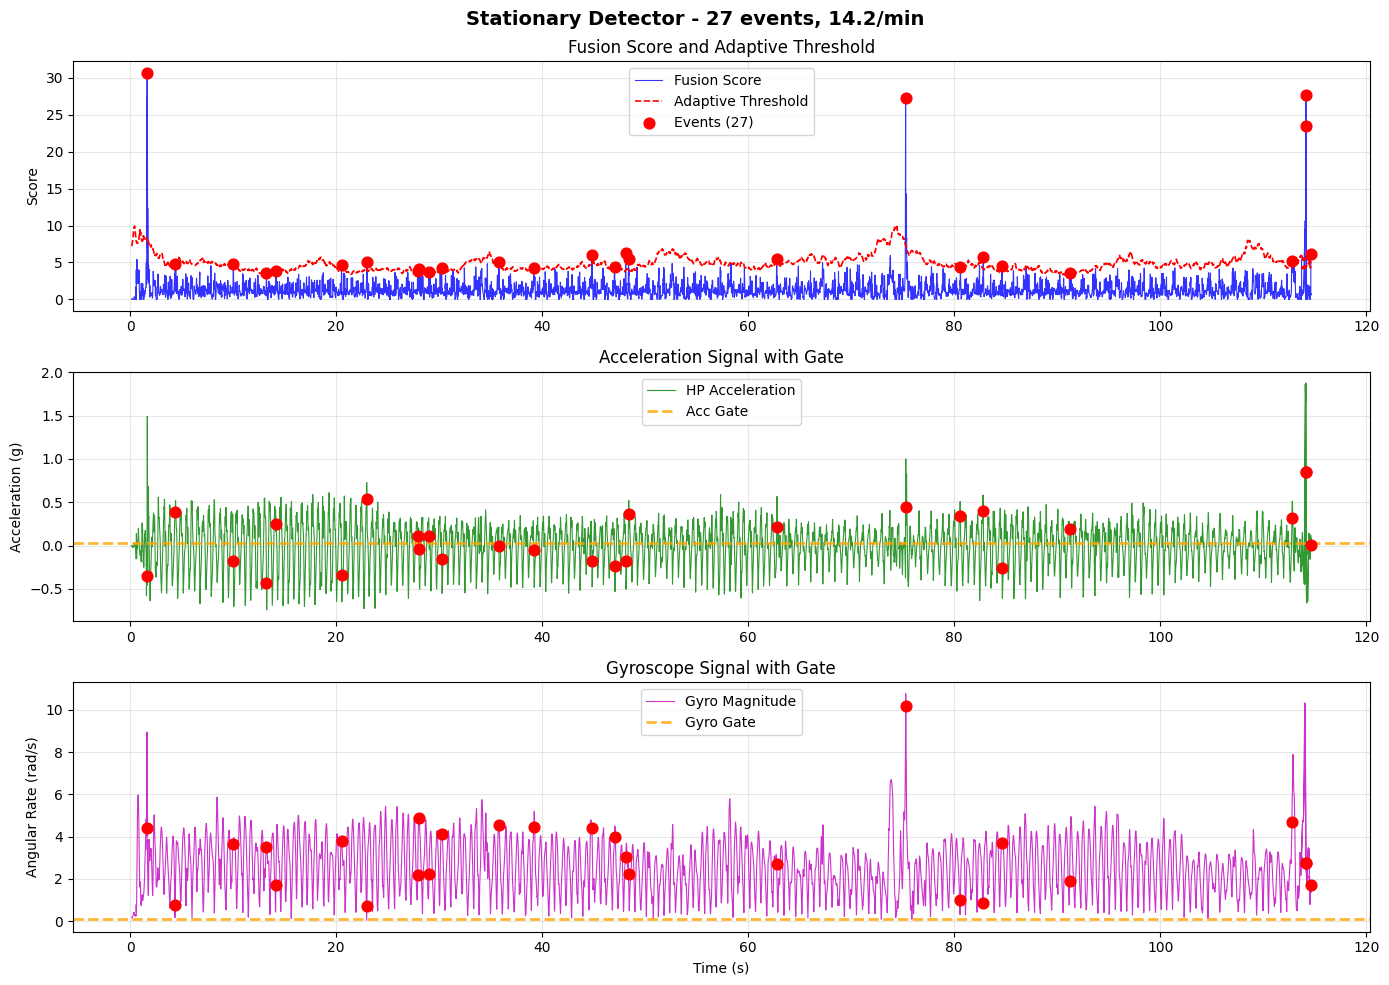


📊 Walking Detector Summary:
  Events detected: 6
  Detection rate: 3.1 events/min
  Median IEI: 8.862 s (6.8/min)

🎯 First 3 events:
  Event 1: t=1.66s, score=18.6, acc=0.751g, gyro=3.371rad/s
  Event 2: t=8.19s, score=4.4, acc=0.518g, gyro=0.500rad/s
  Event 3: t=26.93s, score=3.2, acc=0.133g, gyro=4.281rad/s


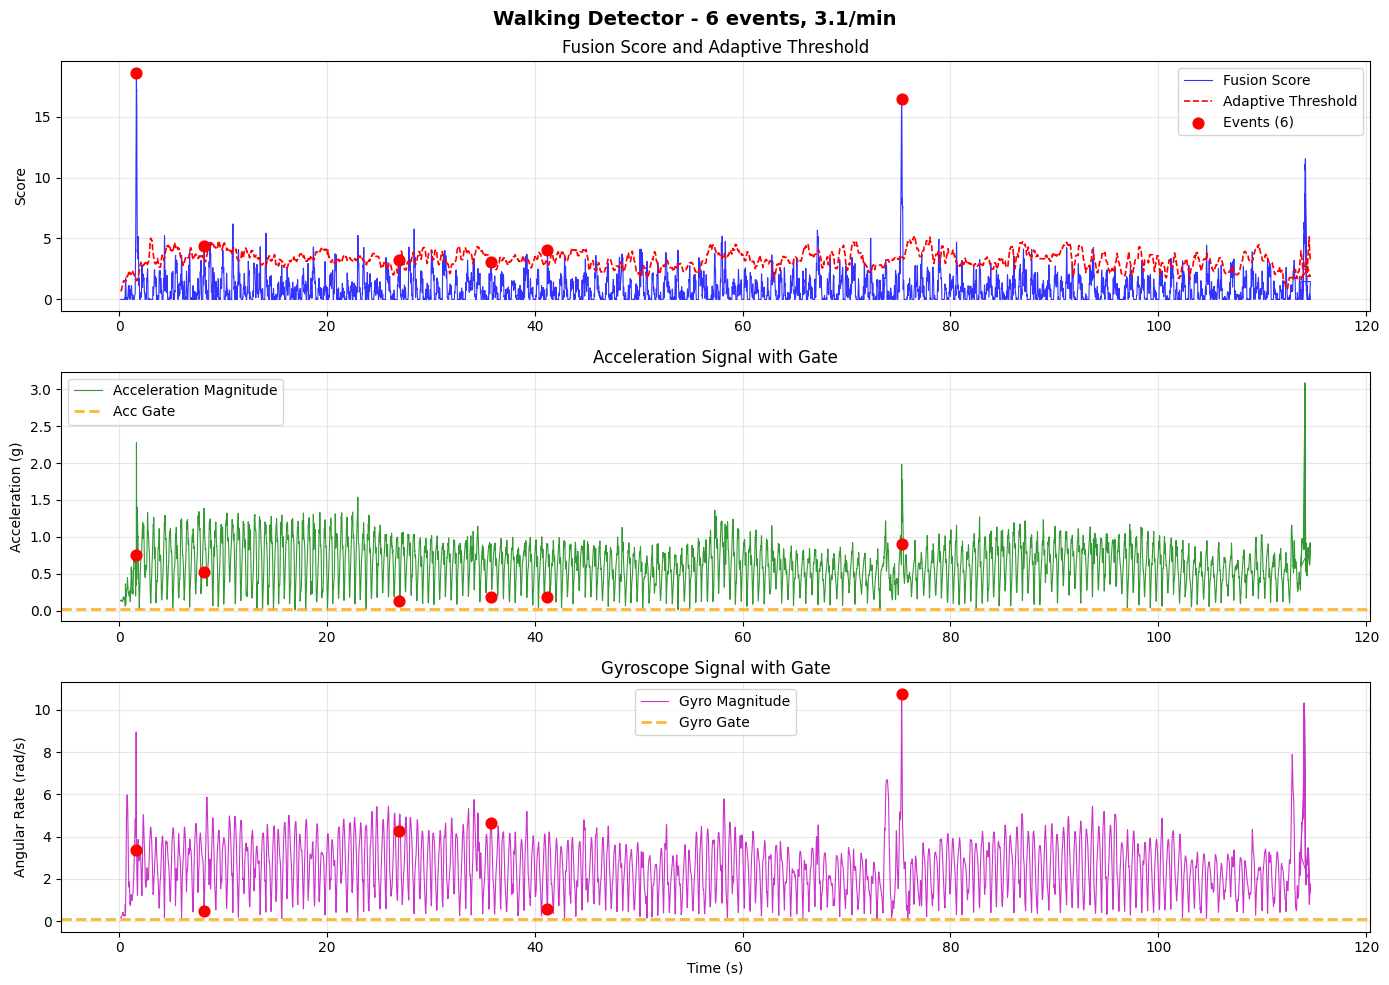


🔍 Detector Comparison:
Metric               Stationary   Walking     
---------------------------------------------
Events               27           6           
Rate (events/min)    14.2         3.1         
Avg Score            1.31         0.94        
Peak Score Range     3.6-30.7
Peak Score Range                  3.1-18.6


In [26]:
# Cell 8: Run Detection

if data is not None:
    print("🔥 Running both detectors...\n")
    
    # Run stationary detector
    print("Running stationary detector...")
    stationary_results = detect_stationary(data, STATIONARY_PARAMS)
    
    # Run walking detector  
    print("Running walking detector...")
    walking_results = detect_walking(data, WALKING_PARAMS)
    
    print("✓ Detection complete!\n")
    
    # Show results
    plot_detection_results(data, stationary_results, "Stationary Detector")
    plot_detection_results(data, walking_results, "Walking Detector")
    
    # Compare results
    compare_detectors(data, stationary_results, walking_results)
    
else:
    print("❌ No data loaded - please fix DATA_PATH and re-run cell 5")

In [ ]:
# Cell 9: Parameter Testing Functions

def test_stationary_params(**param_updates):
    """Test stationary detector with parameter updates"""
    if data is None:
        print("❌ No data loaded")
        return None
        
    # Update parameters
    params = STATIONARY_PARAMS.copy()
    params.update(param_updates)
    
    print("🧪 Testing Stationary Parameters:")
    for key, value in param_updates.items():
        print(f"  {key}: {value}")
    print()
    
    # Run detection
    results = detect_stationary(data, params)
    
    # Show results
    plot_detection_results(data, results, "Stationary Test")
    
    return results

def test_walking_params(**param_updates):
    """Test walking detector with parameter updates"""
    if data is None:
        print("❌ No data loaded")
        return None
        
    # Update parameters
    params = WALKING_PARAMS.copy()
    params.update(param_updates)
    
    print("🧪 Testing Walking Parameters:")
    for key, value in param_updates.items():
        print(f"  {key}: {value}")
    print()
    
    # Run detection
    results = detect_walking(data, params)
    
    # Show results  
    plot_detection_results(data, results, "Walking Test")
    
    return results

def quick_compare(stat_params=None, walk_params=None):
    """Quick comparison of both detectors with optional parameter updates"""
    if data is None:
        print("❌ No data loaded")
        return None, None
        
    # Prepare parameters
    stat_p = STATIONARY_PARAMS.copy()
    walk_p = WALKING_PARAMS.copy()
    
    if stat_params:
        stat_p.update(stat_params)
    if walk_params:
        walk_p.update(walk_params)
        
    # Run detectors
    stat_results = detect_stationary(data, stat_p)
    walk_results = detect_walking(data, walk_p)
    
    # Quick comparison
    duration = data['time'][-1] - data['time'][0]
    stat_rate = (len(stat_results['idxs']) / duration) * 60
    walk_rate = (len(walk_results['idxs']) / duration) * 60
    
    print(f"⚡ Quick Results:")
    print(f"  Stationary: {len(stat_results['idxs'])} events ({stat_rate:.1f}/min)")
    print(f"  Walking:    {len(walk_results['idxs'])} events ({walk_rate:.1f}/min)")
    
    return stat_results, walk_results

print("✓ Parameter testing functions loaded")
print("\n💡 Usage examples:")
print("  test_stationary_params(k_mad=6.0, acc_gate=0.030)")
print("  test_walking_params(k_mad=4.5, corr_min=0.35)")
print("  quick_compare({'k_mad': 6.0}, {'k_mad': 4.5})")

In [ ]:
# Cell 10: Analysis and Comparison Tools

def analyze_components(results):
    """Analyze individual components of the fusion score"""
    if 'components' not in results:
        print("No component analysis available for walking detector")
        return
        
    components = results['components']
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('Stationary Detector - Component Analysis', fontsize=14)
    
    t = data['time']
    
    # Plot each component
    axes[0,0].plot(t, components['z_a'], label='Z-score Acceleration')
    axes[0,0].set_title('Acceleration Z-Score')
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].plot(t, components['z_g'], 'orange', label='Z-score Gyroscope')
    axes[0,1].set_title('Gyroscope Z-Score')
    axes[0,1].grid(True, alpha=0.3)
    
    axes[1,0].plot(t, components['z_da'], 'green', label='Z-score Acc Derivative')
    axes[1,0].set_title('Acceleration Derivative Z-Score')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xlabel('Time (s)')
    
    axes[1,1].plot(t, components['z_dg'], 'red', label='Z-score Gyro Derivative')
    axes[1,1].set_title('Gyroscope Derivative Z-Score')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xlabel('Time (s)')
    
    # Mark events on all subplots
    if len(results['idxs']) > 0:
        event_times = [results['events'][i]['time'] for i in range(len(results['idxs']))]
        for ax in axes.flat:
            for et in event_times:
                ax.axvline(et, color='red', alpha=0.5, linestyle='--')
    
    plt.tight_layout()
    plt.show()

def analyze_walking_features(results):
    """Analyze walking detector specific features"""
    if results['detector_type'] != 'walking':
        print("This analysis is only for walking detector results")
        return
        
    if len(results['events']) == 0:
        print("No events to analyze")
        return
        
    events = results['events']
    
    # Extract walking-specific metrics
    corr_peaks = [e.get('corr_peak', 0) for e in events]
    energy_ratios = [e.get('energy_ratio', 0) for e in events]
    rise_times = [e.get('rise_time', 0) for e in events]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Walking Detector - Feature Analysis', fontsize=14)
    
    # Correlation peaks
    axes[0].hist(corr_peaks, bins=10, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Cross-Correlation Peak')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Cross-Correlation Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # Energy ratios
    axes[1].hist(energy_ratios, bins=10, alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_xlabel('Energy Ratio')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Energy Ratio Distribution')
    axes[1].grid(True, alpha=0.3)
    
    # Rise times
    axes[2].hist(rise_times, bins=10, alpha=0.7, edgecolor='black', color='green')
    axes[2].set_xlabel('Rise Time')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Rise Time Distribution')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Walking Features Summary:")
    print(f"  Correlation peaks: {np.mean(corr_peaks):.3f} ± {np.std(corr_peaks):.3f}")
    print(f"  Energy ratios: {np.mean(energy_ratios):.3f} ± {np.std(energy_ratios):.3f}")
    print(f"  Rise times: {np.mean(rise_times):.1f} ± {np.std(rise_times):.1f}")

def export_events_csv(results, filename):
    """Export detected events to CSV"""
    if len(results['events']) == 0:
        print("No events to export")
        return
        
    # Create DataFrame
    events_df = pd.DataFrame(results['events'])
    
    # Save to CSV
    events_df.to_csv(filename, index=False)
    print(f"✓ Exported {len(results['events'])} events to {filename}")
    print(f"  Columns: {list(events_df.columns)}")

print("✓ Analysis tools loaded")
print("\n💡 Analysis functions:")
print("  analyze_components(stationary_results)     # Analyze z-score components")
print("  analyze_walking_features(walking_results)  # Analyze walking features")
print("  export_events_csv(results, 'events.csv')   # Export events to CSV")

In [23]:
# DEBUG VERSION OF WALKING DETECTOR
# This version shows exactly why events are being rejected

def detect_walking_debug(data, params):
    """Walking detector with detailed rejection logging"""
    t, fs = data['time'], data['fs']
    a, g = data['acc_mag'], data['gyro_mag']
    
    print(f"🔍 DEBUG: Starting walking detection...")
    print(f"   Duration: {t[-1]:.1f}s, Samples: {len(t)}, fs: {fs:.1f}Hz")
    
    # Signal preprocessing
    a_hp = hp_moving_mean(a, fs, params['hp_win'])
    a_bp = bandpass(a_hp, fs, params['bp_lo'], params['bp_hi'])
    g_bp = bandpass(g, fs, params['bp_lo'], params['bp_hi'])
    
    # Envelopes
    a_env = rms_envelope(a_bp, fs, params['env_win'])
    g_env = rms_envelope(g_bp, fs, params['env_win'])
    
    # Low-frequency components for energy ratio
    a_low = gait_lowband(a, fs, params['low_lo'], params['low_hi'])
    g_low = gait_lowband(g, fs, params['low_lo'], params['low_hi'])
    
    # Z-scores on envelopes
    z_a = robust_z(a_env, fs, params['thr_win'])
    z_g = robust_z(g_env, fs, params['thr_win'])
    
    # Fusion score (2-component for walking)
    score = np.sqrt(np.maximum(z_a, 0)**2 + np.maximum(z_g, 0)**2)
    
    # Adaptive threshold
    thr = adaptive_threshold(score, fs, params['thr_win'], params['k_mad'])
    
    print(f"   Score range: {score.min():.2f} - {score.max():.2f}")
    print(f"   Threshold range: {thr.min():.2f} - {thr.max():.2f}")
    
    # Find candidates above threshold
    candidates = np.where(score > thr)[0]
    print(f"   Initial candidates above threshold: {len(candidates)}")
    
    if len(candidates) == 0:
        print("   ❌ NO CANDIDATES - threshold too high!")
        return {'idxs': np.array([], dtype=int), 'score': score, 'threshold': thr, 'debug_stats': {}}
    
    # Peak detection with multiple validations
    n = len(score)
    refr = int(round(params['refractory_s'] * fs))
    pw = int(round(params['peakwin_s'] * fs))
    gate = int(round(params['gatewin_s'] * fs))
    align = int(round(params['align_tol_s'] * fs))
    decay_dt = int(round(params['decay_dt_s'] * fs))
    rise_max = int(round(params['rise_max_s'] * fs))
    
    # Debug counters
    debug_stats = {
        'candidates': len(candidates),
        'rejected_refractory': 0,
        'rejected_not_peak': 0,
        'rejected_gates': 0,
        'rejected_alignment': 0,
        'rejected_rise_decay': 0,
        'rejected_energy': 0,
        'rejected_correlation': 0,
        'rejected_min_iei': 0,
        'accepted': 0
    }
    
    idxs = []
    last = -10**9
    events = []
    
    for i in candidates:
        # 1. Refractory period check
        if i - last < refr:
            debug_stats['rejected_refractory'] += 1
            continue
            
        # 2. Local maxima check
        i0 = max(0, i - pw)
        i1 = min(n, i + pw + 1)
        if i != i0 + np.argmax(score[i0:i1]):
            debug_stats['rejected_not_peak'] += 1
            continue
            
        # 3. Basic gate checks
        g0 = max(0, i - gate)
        g1 = min(n, i + gate + 1)
        max_acc = np.nanmax(a_hp[g0:g1])
        max_gyro = np.nanmax(g[g0:g1])
        if max_acc < params['acc_gate'] or max_gyro < params['gyro_gate']:
            debug_stats['rejected_gates'] += 1
            # Debug: show what failed
            if len(idxs) < 3:  # Only show first few rejections
                print(f"      Gate reject t={t[i]:.1f}s: acc={max_acc:.3f}<{params['acc_gate']:.3f} or gyro={max_gyro:.3f}<{params['gyro_gate']:.3f}")
            continue
            
        # 4. Peak alignment check
        ia = g0 + np.argmax(a_env[g0:g1])
        ig = g0 + np.argmax(g_env[g0:g1])
        alignment_diff = abs(ia - ig)
        if alignment_diff > align:
            debug_stats['rejected_alignment'] += 1
            if len(idxs) < 3:
                print(f"      Align reject t={t[i]:.1f}s: diff={alignment_diff}>{align}")
            continue
            
        # 5. Rise time analysis
        pre = max(0, ia - int(round(0.2 * fs)))
        peak = float(a_env[ia])
        
        if peak <= 0:
            debug_stats['rejected_rise_decay'] += 1
            continue
            
        lvl10 = 0.1 * peak
        lvl90 = 0.9 * peak
        
        sub = a_env[pre:ia+1]
        b10 = np.where(sub <= lvl10)[0]
        b90 = np.where(sub <= lvl90)[0]
        
        if len(b10) == 0 or len(b90) == 0:
            debug_stats['rejected_rise_decay'] += 1
            continue
            
        rise = (pre + b90[-1]) - (pre + b10[-1])
        
        # 6. Decay check
        dec_a = float(a_env[min(n-1, ia + decay_dt)])
        decay_frac = dec_a / peak if peak > 0 else 1.0
        
        if not (0 <= rise <= rise_max and decay_frac <= params['decay_frac_max']):
            debug_stats['rejected_rise_decay'] += 1
            if len(idxs) < 3:
                print(f"      Rise/Decay reject t={t[i]:.1f}s: rise={rise}>{rise_max} or decay={decay_frac:.3f}>{params['decay_frac_max']:.3f}")
            continue
            
        # 7. Energy ratio check
        w = int(round(0.15 * fs))
        j0 = max(0, i - w)
        j1 = min(n, i + w + 1)
        
        E_pinch = float(np.sum(a_bp[j0:j1]**2 + g_bp[j0:j1]**2))
        E_low = float(np.sum(a_low[j0:j1]**2 + g_low[j0:j1]**2)) + 1e-12
        energy_ratio = E_pinch / E_low
        
        if energy_ratio < params['energy_ratio_min']:
            debug_stats['rejected_energy'] += 1
            if len(idxs) < 3:
                print(f"      Energy reject t={t[i]:.1f}s: ratio={energy_ratio:.4f}<{params['energy_ratio_min']:.4f}")
            continue
            
        # 8. Cross-correlation check
        seg_a = a_bp[j0:j1] - np.mean(a_bp[j0:j1])
        seg_g = g_bp[j0:j1] - np.mean(g_bp[j0:j1])
        denom = np.sqrt(np.sum(seg_a**2) * np.sum(seg_g**2)) + 1e-12
        
        from scipy.signal import correlate
        xcorr = correlate(seg_a, seg_g, mode='full')
        lags = np.arange(-len(seg_a) + 1, len(seg_a))
        corr_lag = int(round(params['corr_lag_s'] * fs))
        mask = np.where(np.abs(lags) <= corr_lag)[0]
        
        corr_peak = np.max(np.abs(xcorr[mask])) / denom if denom > 0 else 0.0
        
        if corr_peak < params['corr_min']:
            debug_stats['rejected_correlation'] += 1
            if len(idxs) < 3:
                print(f"      Corr reject t={t[i]:.1f}s: peak={corr_peak:.3f}<{params['corr_min']:.3f}")
            continue
            
        # 9. Minimum inter-event interval
        if len(idxs) and (i - idxs[-1]) < int(round(params['min_iei_s'] * fs)):
            debug_stats['rejected_min_iei'] += 1
            continue
            
        # All checks passed!
        debug_stats['accepted'] += 1
        idxs.append(i)
        last = i
        
        events.append({
            'index': i,
            'time': t[i],
            'score': score[i],
            'acc_peak': a_hp[i],
            'gyro_peak': g[i],
            'threshold': thr[i],
            'corr_peak': corr_peak,
            'energy_ratio': energy_ratio,
            'rise_time': rise
        })
    
    # Print debug summary
    print(f"\n📊 REJECTION ANALYSIS:")
    total_rejected = sum(v for k, v in debug_stats.items() if k.startswith('rejected_'))
    print(f"   Candidates: {debug_stats['candidates']}")
    print(f"   Accepted: {debug_stats['accepted']}")
    print(f"   Total Rejected: {total_rejected}")
    print(f"   Rejection Breakdown:")
    for key, count in debug_stats.items():
        if key.startswith('rejected_') and count > 0:
            reason = key.replace('rejected_', '').replace('_', ' ').title()
            pct = 100 * count / debug_stats['candidates'] if debug_stats['candidates'] > 0 else 0
            print(f"     {reason}: {count} ({pct:.1f}%)")
    
    return {
        'idxs': np.array(idxs, dtype=int),
        'events': events,
        'score': score,
        'threshold': thr,
        'debug_stats': debug_stats,
        'detector_type': 'walking_debug'
    }

print("✓ Debug walking detector loaded")
print("Usage: detect_walking_debug(data, WALKING_PARAMS)")

✓ Debug walking detector loaded
Usage: detect_walking_debug(data, WALKING_PARAMS)


In [27]:
detect_walking_debug(data, WALKING_PARAMS)

🔍 DEBUG: Starting walking detection...
   Duration: 114.6s, Samples: 11459, fs: 99.3Hz
   Score range: 0.00 - 18.60
   Threshold range: 0.66 - 5.18
   Initial candidates above threshold: 547

📊 REJECTION ANALYSIS:
   Candidates: 547
   Accepted: 6
   Total Rejected: 541
   Rejection Breakdown:
     Refractory: 28 (5.1%)
     Not Peak: 454 (83.0%)
     Rise Decay: 59 (10.8%)


{'idxs': array([ 149,  797, 2658, 3538, 4077, 7461]),
 'events': [{'index': np.int64(149),
   'time': np.float64(1.662553071975708),
   'score': np.float64(18.604966783082617),
   'acc_peak': np.float64(0.7512741455581082),
   'gyro_peak': np.float64(3.3709619749731328),
   'threshold': np.float64(1.5506954383253806),
   'corr_peak': np.float64(0.7070211159019786),
   'energy_ratio': 0.6139487514474505,
   'rise_time': np.int64(15)},
  {'index': np.int64(797),
   'time': np.float64(8.188040494918823),
   'score': np.float64(4.413212723955889),
   'acc_peak': np.float64(0.5183915322882996),
   'gyro_peak': np.float64(0.49960174223687126),
   'threshold': np.float64(3.3686600502219948),
   'corr_peak': np.float64(0.9291706153302434),
   'energy_ratio': 0.06620332128765864,
   'rise_time': np.int64(14)},
  {'index': np.int64(2658),
   'time': np.float64(26.928763151168823),
   'score': np.float64(3.2180346387667735),
   'acc_peak': np.float64(0.1331982522391434),
   'gyro_peak': np.float6

In [30]:
def detect_walking_simple(data, params):
      """Simplified walking detector - removes strict peak and waveform validations"""
      t, fs = data['time'], data['fs']
      a, g = data['acc_mag'], data['gyro_mag']

      # Same preprocessing as original
      a_hp = hp_moving_mean(a, fs, params['hp_win'])
      a_bp = bandpass(a_hp, fs, params['bp_lo'], params['bp_hi'])
      g_bp = bandpass(g, fs, params['bp_lo'], params['bp_hi'])

      # Envelopes
      a_env = rms_envelope(a_bp, fs, params['env_win'])
      g_env = rms_envelope(g_bp, fs, params['env_win'])

      # Z-scores on envelopes
      z_a = robust_z(a_env, fs, params['thr_win'])
      z_g = robust_z(g_env, fs, params['thr_win'])

      # Fusion score
      score = np.sqrt(np.maximum(z_a, 0)**2 + np.maximum(z_g, 0)**2)

      # Adaptive threshold
      thr = adaptive_threshold(score, fs, params['thr_win'], params['k_mad'])

      # SIMPLIFIED EVENT DETECTION - Only basic validations
      n = len(score)
      refr = int(round(params['refractory_s'] * fs))
      gate = int(round(params['gatewin_s'] * fs))

      idxs = []
      last = -10**9
      events = []

      # Get all candidates above threshold
      candidates = np.where(score > thr)[0]
      print(f"Simple detector: {len(candidates)} candidates above threshold")

      for i in candidates:
          # 1. Refractory period check
          if i - last < refr:
              continue

          # 2. ONLY basic gate checks (no complex peak validation)
          g0 = max(0, i - gate)
          g1 = min(n, i + gate + 1)
          max_acc = np.nanmax(a_hp[g0:g1])
          max_gyro = np.nanmax(g[g0:g1])
          if max_acc < params['acc_gate'] or max_gyro < params['gyro_gate']:
              continue

          # 3. Simple minimum interval check
          if len(idxs) and (i - idxs[-1]) < int(round(params['min_iei_s'] * fs)):
              continue

          # Accept event - no other validations!
          idxs.append(i)
          last = i

          events.append({
              'index': i,
              'time': t[i],
              'score': score[i],
              'acc_peak': a_hp[i],
              'gyro_peak': g[i],
              'threshold': thr[i],
          })

      print(f"Simple detector: {len(idxs)} events accepted")

      return {
          'idxs': np.array(idxs, dtype=int),
          'events': events,
          'score': score,
          'threshold': thr,
          'detector_type': 'walking_simple'
      }

def test_walking_simple(**param_updates):
    """Test simplified walking detector"""
    if data is None:
        print("❌ No data loaded")
        return None

    # Update parameters
    params = WALKING_PARAMS.copy()
    params.update(param_updates)

    print("🧪 Testing Simplified Walking Detector:")
    for key, value in param_updates.items():
        print(f"  {key}: {value}")
    print()

    # Run simplified detection
    results = detect_walking_simple(data, params)

    # Show results  
    plot_detection_results(data, results, "Simplified Walking Test")

    return results

  # Test it:
  # test_walking_simple(k_mad=3.0)
  # test_walking_simple(k_mad=2.5, acc_gate=0.020, gyro_gate=0.08)

In [31]:
detect_walking_debug(data, WALKING_PARAMS)

🔍 DEBUG: Starting walking detection...
   Duration: 114.6s, Samples: 11459, fs: 99.3Hz
   Score range: 0.00 - 18.60
   Threshold range: 0.66 - 5.18
   Initial candidates above threshold: 547

📊 REJECTION ANALYSIS:
   Candidates: 547
   Accepted: 6
   Total Rejected: 541
   Rejection Breakdown:
     Refractory: 28 (5.1%)
     Not Peak: 454 (83.0%)
     Rise Decay: 59 (10.8%)


{'idxs': array([ 149,  797, 2658, 3538, 4077, 7461]),
 'events': [{'index': np.int64(149),
   'time': np.float64(1.662553071975708),
   'score': np.float64(18.604966783082617),
   'acc_peak': np.float64(0.7512741455581082),
   'gyro_peak': np.float64(3.3709619749731328),
   'threshold': np.float64(1.5506954383253806),
   'corr_peak': np.float64(0.7070211159019786),
   'energy_ratio': 0.6139487514474505,
   'rise_time': np.int64(15)},
  {'index': np.int64(797),
   'time': np.float64(8.188040494918823),
   'score': np.float64(4.413212723955889),
   'acc_peak': np.float64(0.5183915322882996),
   'gyro_peak': np.float64(0.49960174223687126),
   'threshold': np.float64(3.3686600502219948),
   'corr_peak': np.float64(0.9291706153302434),
   'energy_ratio': 0.06620332128765864,
   'rise_time': np.int64(14)},
  {'index': np.int64(2658),
   'time': np.float64(26.928763151168823),
   'score': np.float64(3.2180346387667735),
   'acc_peak': np.float64(0.1331982522391434),
   'gyro_peak': np.float6

Ultra-simple: 1205 candidates
Ultra-simple: 189 events accepted

📊 Ultra-Simple Walking Summary:
  Events detected: 189
  Detection rate: 99.1 events/min
  Median IEI: 0.433 s (138.6/min)

🎯 First 3 events:
  Event 1: t=0.61s, score=1.2, acc=-0.129g, gyro=0.442rad/s
  Event 2: t=1.56s, score=1.9, acc=-0.120g, gyro=4.844rad/s
  Event 3: t=1.68s, score=17.1, acc=0.729g, gyro=3.846rad/s


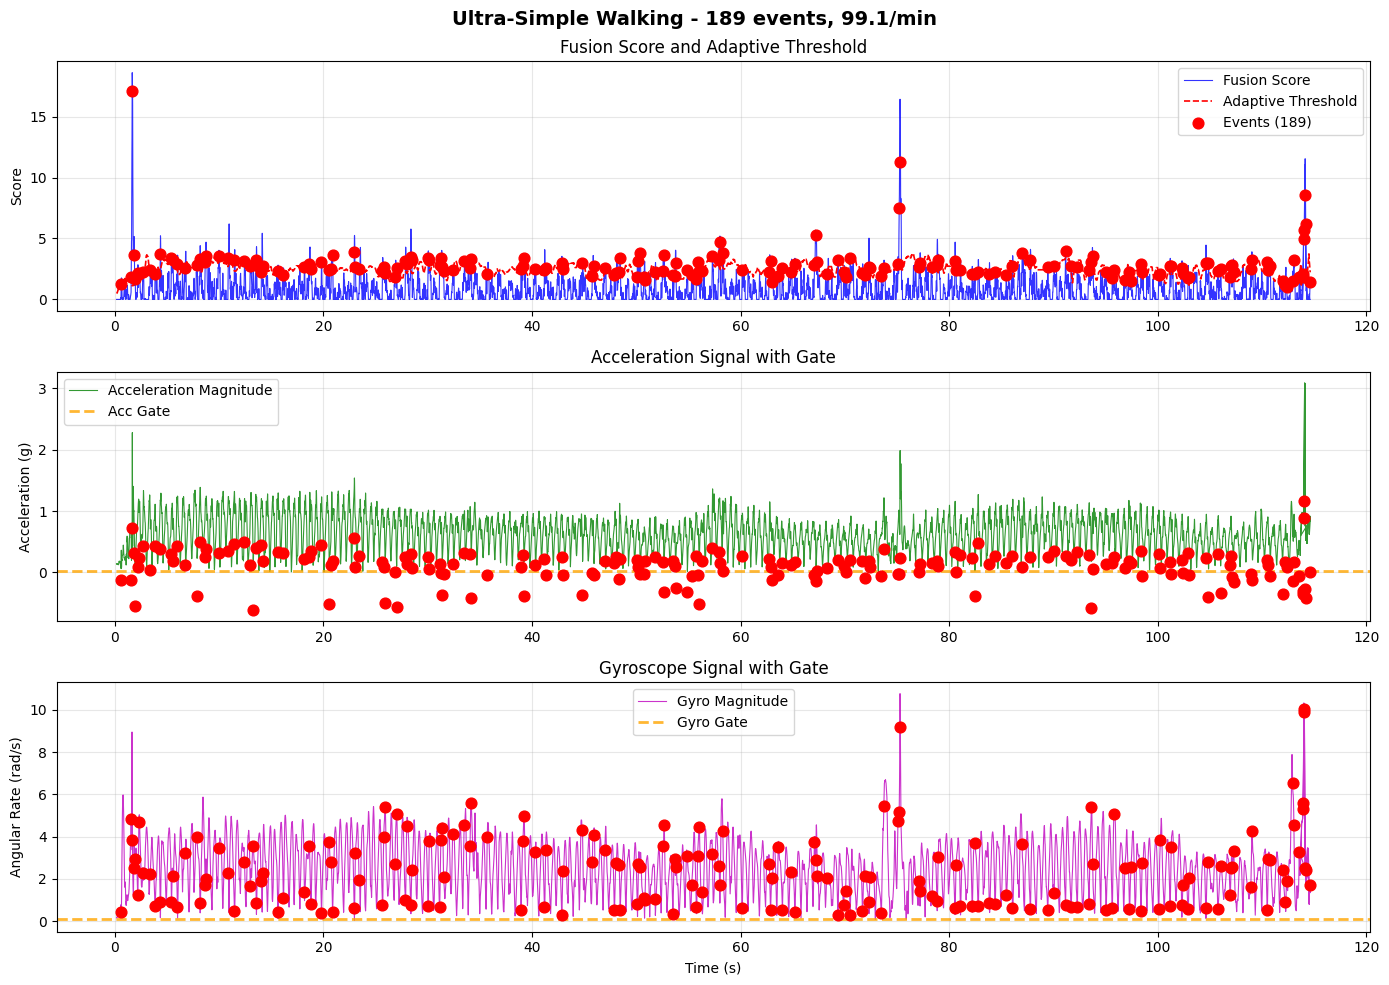

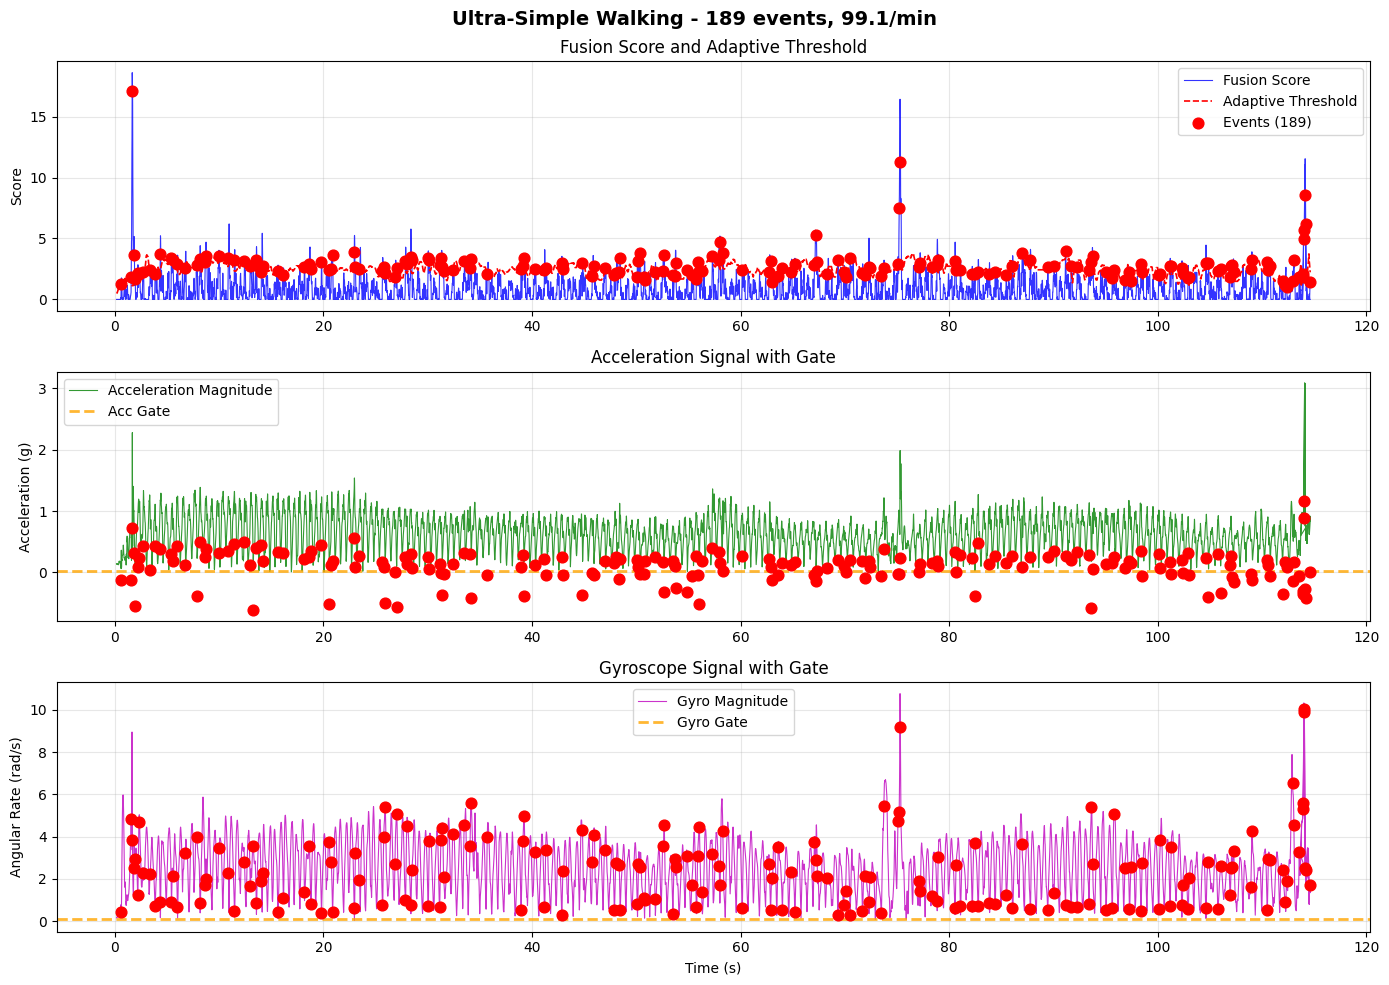

In [34]:
def detect_walking_ultra_simple(data, params):
      """Ultra-simplified walking detector - minimal validations"""
      t, fs = data['time'], data['fs']
      a, g = data['acc_mag'], data['gyro_mag']

      # Same preprocessing
      a_hp = hp_moving_mean(a, fs, params['hp_win'])
      a_bp = bandpass(a_hp, fs, params['bp_lo'], params['bp_hi'])
      g_bp = bandpass(g, fs, params['bp_lo'], params['bp_hi'])

      # Envelopes
      a_env = rms_envelope(a_bp, fs, params['env_win'])
      g_env = rms_envelope(g_bp, fs, params['env_win'])

      # Z-scores
      z_a = robust_z(a_env, fs, params['thr_win'])
      z_g = robust_z(g_env, fs, params['thr_win'])

      # Fusion score
      score = np.sqrt(np.maximum(z_a, 0)**2 + np.maximum(z_g, 0)**2)

      # Adaptive threshold
      thr = adaptive_threshold(score, fs, params['thr_win'], params['k_mad'])

      # ULTRA-SIMPLE: Just threshold + basic gates + refractory
      refr = int(round(params['refractory_s'] * fs))
      gate = int(round(params['gatewin_s'] * fs))

      idxs = []
      last = -10**9
      events = []

      candidates = np.where(score > thr)[0]
      print(f"Ultra-simple: {len(candidates)} candidates")

      for i in candidates:
          # Skip if too close to last event
          if i - last < refr:
              continue

          # Basic signal strength check in window
          g0 = max(0, i - gate)
          g1 = min(len(score), i + gate + 1)

          if (np.nanmax(a_hp[g0:g1]) >= params['acc_gate'] and
              np.nanmax(g[g0:g1]) >= params['gyro_gate']):

              idxs.append(i)
              last = i

              events.append({
                  'index': i,
                  'time': t[i],
                  'score': score[i],
                  'acc_peak': a_hp[i],
                  'gyro_peak': g[i],
                  'threshold': thr[i],
              })

      print(f"Ultra-simple: {len(idxs)} events accepted")

      return {
          'idxs': np.array(idxs, dtype=int),
          'events': events,
          'score': score,
          'threshold': thr,
          'detector_type': 'walking_ultra_simple'
      }

  # Test with very low threshold
results = detect_walking_ultra_simple(data, {**WALKING_PARAMS, 'k_mad': 2.0, 'acc_gate': 0.020, 'gyro_gate': 0.08})
plot_detection_results(data, results, "Ultra-Simple Walking")